# Plotting some waves

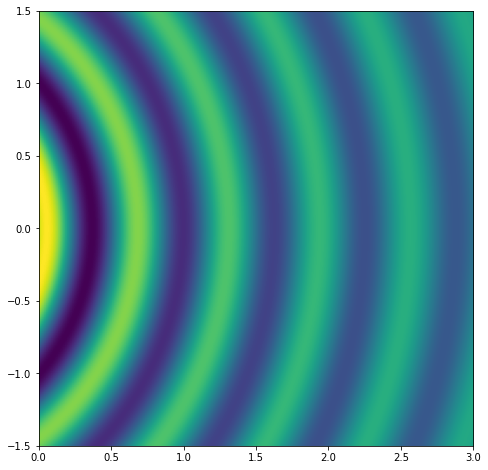

In [1]:
import numpy as np
import matplotlib.pylab as plt

k = 10.


def g(x, y):
    """Evaluate the acoustic Green's function."""
    return np.exp(1j * k * np.linalg.norm(x - y)) / 4 / np.pi / np.linalg.norm(x - y)


sources = np.array([[-1.2, 0., 0.]])
magnitudes = np.array([1.0])

img_size = 250
values = np.empty((img_size, img_size), dtype="complex128")

xmin = 0
xmax = 3
ymin = -1.5
ymax = 1.5

# plt.imshow interprets data as the colour of pixels starting at the top left then 
# row by row. For example, if an image was 5 pixels wide, the order of the pixels
# would be:
# 0 1 2 3 4
# 5 6 7 8 9
# etc
# Due to this ordering, the y values here might at first glance appear to be backwards
for i in range(img_size):
    y = ymax + (ymin - ymax) * i / (img_size - 1)
    for j in range(img_size):
        x = xmin + (xmax - xmin) * j / (img_size - 1)
        point = np.array([x, y, 0])
        v = 0
        for m, s in zip(magnitudes, sources):
            v += m * g(s, point)
        values[i, j] = v     

fig = plt.figure(figsize=(8,8))
plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
plt.show()

In [2]:
def plot(sources:"np.array", magnitudes:"np.array", img_size:int,
         xmin:float, xmax:float, ymin:float, ymax:float):

  values = np.empty((img_size, img_size), dtype="complex128")

  # plt.imshow interprets data as the colour of pixels starting at the top left then 
  # row by row. For example, if an image was 5 pixels wide, the order of the pixels
  # would be:
  # 0 1 2 3 4
  # 5 6 7 8 9
  # etc
  # Due to this ordering, the y values here might at first glance appear to be backwards
  for i in range(img_size):
      y = ymax + (ymin - ymax) * i / (img_size - 1)
      for j in range(img_size):
          x = xmin + (xmax - xmin) * j / (img_size - 1)
          point = np.array([x, y, 0])
          v = 0
          for m, s in zip(magnitudes, sources):
              v += m * g(s, point)
          values[i, j] = v     

  fig = plt.figure(figsize=(8,8))
  plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
  plt.show()

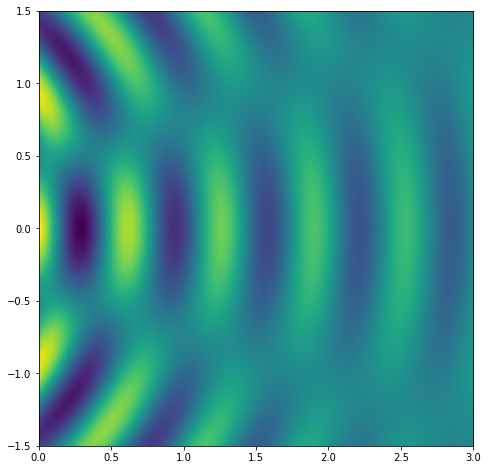

In [3]:
plot(np.array([[-1.2, 0.5, 0.], [-1.2, -0.5, 0.]]), np.array([1.0, 1.0]), 250, 0., 3., -1.5, 1.5)

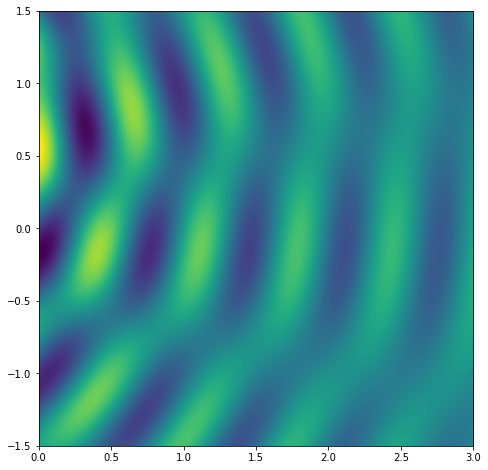

In [4]:
yzvalue = 2 * np.random.rand(4,2) - np.ones((4,2))
xvalue = np.full((4, 1), -1.2)
randsource = np.hstack((xvalue, yzvalue))
randmagnitude = np.random.rand(4)

plot(randsource, randmagnitude, 250, 0., 3., -1.5, 1.5)

# GPU acceleration

In [5]:
import numba
from numba import cuda
import math

cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-01186090-cb5b-0770-b4cc-d322f946e521
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


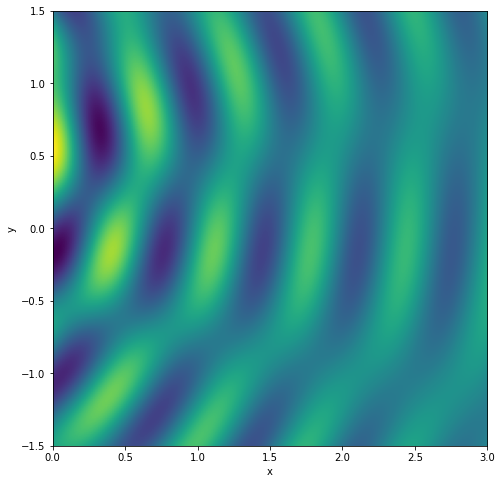

In [6]:
import numpy as np
import numba
import math
from numba import cuda

sigma = .1

plot_grid = np.mgrid[xmin:xmax:img_size * 1j, ymin:ymax:img_size * 1j]
targets = np.vstack((plot_grid[0].flatten(),
                     plot_grid[1].flatten(),
                     np.zeros(plot_grid[0].size))).T

nsources = 4

SX = 16
SY = nsources

@cuda.jit
def greens_evaluation_cuda(sources, targets, weights, result):
    local_result = cuda.shared.array((SX, nsources), numba.float32)
    local_targets = cuda.shared.array((SX, 3), numba.float32)
    local_sources = cuda.shared.array((SY, 3), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[ty]
        
    # Let us now sync all threads
    
    cuda.syncthreads()
    
    # Now compute the interactions
    
    diff = numba.float32(0)
    
    for index in range(3):
      diff += (local_targets[tx, index] - local_sources[ty, index])**2
    diff = math.sqrt(diff)
    local_result[tx, ty] = math.cos(k * diff) / (numba.float32(4) * numba.float32(np.pi) * diff) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    
    if ty == 0:
        res = numba.float32(0)
        for index in range(nsources):
            res += local_result[tx, index]
        result[px] = res

nblocks = (targets.shape[0] + SX - 1) // SX
result = cuda.to_device(np.zeros(len(targets), dtype=np.float32))
greens_evaluation_cuda[(nblocks, 1), (SX, SY)](randsource.astype('float32'), targets.astype('float32'), randmagnitude.astype('float32'), result)

result_xy = result.copy_to_host()[: img_size * img_size].reshape(img_size, img_size).T

fig = plt.figure(figsize=(8,8))
plt.imshow(result_xy[::-1], extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


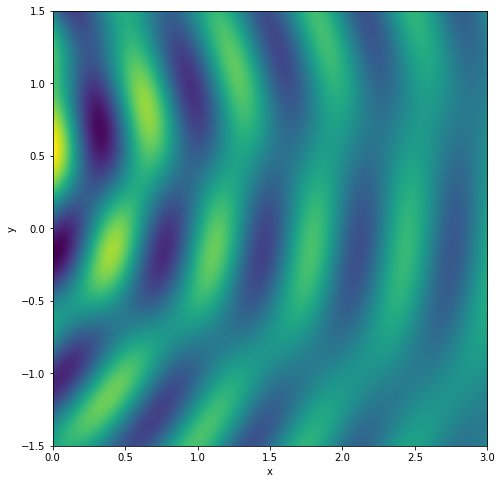

In [7]:
@cuda.jit
def greens_evaluation_cuda_f64(sources, targets, weights, result):
    local_result = cuda.shared.array((SX, nsources), numba.float64)
    local_targets = cuda.shared.array((SX, 3), numba.float64)
    local_sources = cuda.shared.array((SY, 3), numba.float64)
    local_weights = cuda.shared.array(SY, numba.float64)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[ty]
        
    # Let us now sync all threads
    
    cuda.syncthreads()
    
    # Now compute the interactions
    
    diff = numba.float64(0)
    
    for index in range(3):
      diff += (local_targets[tx, index] - local_sources[ty, index])**2
    diff = math.sqrt(diff)
    local_result[tx, ty] = math.cos(k * diff) / (numba.float64(4) * numba.float64(np.pi) * diff) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    
    if ty == 0:
        res = numba.float64(0)
        for index in range(nsources):
            res += local_result[tx, index]
        result[px] = res

result = cuda.to_device(np.zeros(len(targets), dtype=np.float64))
greens_evaluation_cuda_f64[(nblocks, 1), (SX, SY)](randsource.astype('float64'), targets.astype('float64'), randmagnitude.astype('float64'), result)

result_xy = result.copy_to_host()[: img_size * img_size].reshape(img_size, img_size).T

fig = plt.figure(figsize=(8,8))
plt.imshow(result_xy[::-1], extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Comparing GPU and CPU acceleration

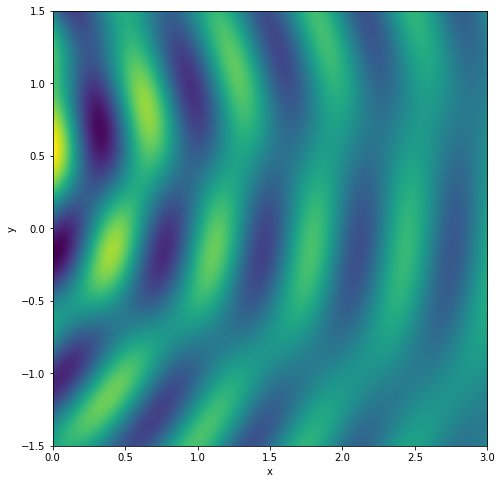

In [8]:
@numba.njit(parallel=True)
def greens_evaluation(sources, targets, weights, result):
    """Evaluate the green's function sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
      diff = np.sqrt(np.sum(np.abs(targets[index] - sources)**2, axis=1))
      result[index] = np.sum(np.exp(1j * k * diff) / (4 * np.pi**2 * diff) * weights)

result = np.zeros(len(targets), dtype=np.complex128)
greens_evaluation(randsource, targets, randmagnitude, result)

result_xy = np.real(result[: img_size * img_size].reshape(img_size, img_size).T)

fig = plt.figure(figsize=(8,8))
plt.imshow(result_xy[::-1], extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
from timeit import timeit

result = cuda.to_device(np.zeros(len(targets), dtype=np.float32))
t_gpu = timeit("greens_evaluation_cuda[(nblocks, 1), (SX, SY)](randsource, targets, randmagnitude, result)",
               "from numba import cuda; import numba; import numpy as np; import math; from __main__ import greens_evaluation_cuda, randsource, targets, randmagnitude, result, nblocks, SX, SY",
               number=1)
result = np.zeros(len(targets), dtype=np.complex128)
t_cpu = timeit("greens_evaluation(randsource, targets, randmagnitude, result)",
               "import numpy as np; from __main__ import greens_evaluation, randsource, targets, randmagnitude, result",
               number=1)
print(t_gpu, t_cpu)

0.2594254919999912 0.033317712000098254


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [10]:
t_cpu/t_gpu

0.12842882842099182

# Extension task

In [11]:
def time_for_nval(n):
  result = cuda.to_device(np.zeros(len(targets), dtype=np.float32))
  t_gpu = timeit("greens_evaluation_cuda[(nblocks, 1), (SX, SY)](randsource, targets, randmagnitude, result)",
                "from numba import cuda; import numba; import numpy as np; import math; from __main__ import greens_evaluation_cuda, randsource, targets, randmagnitude, result, nblocks, SX, SY",
                number=1)
  result = np.zeros(len(targets), dtype=np.complex128)
  # compile it by running it once
  greens_evaluation(randsource, targets, randmagnitude, result)
  t_cpu = timeit("greens_evaluation(randsource, targets, randmagnitude, result)",
                "import numpy as np; from __main__ import greens_evaluation, randsource, targets, randmagnitude, result",
                number=1)
  return [t_gpu, t_cpu]

times = np.zeros((10, 2))
img_sizes = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
for i, n in enumerate(img_sizes):
  img_size = n
  plot_grid = np.mgrid[xmin:xmax:img_size * 1j, ymin:ymax:img_size * 1j]
  targets = np.vstack((plot_grid[0].flatten(),
                      plot_grid[1].flatten(),
                      np.zeros(plot_grid[0].size))).T
  times[i, :] = time_for_nval(n)

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


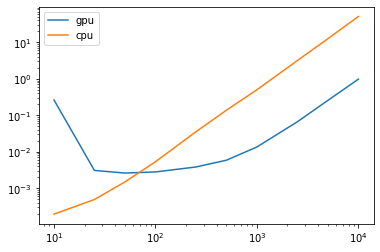

In [13]:
plt.plot(img_sizes, times[:, 0])
plt.plot(img_sizes, times[:, 1])
plt.xscale("log")
plt.yscale("log")
plt.legend(["gpu", "cpu"])